In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv("superstore_data.csv")

# Data Cleaning

1. Adjust existing features and add new ones
2. Handle missing values in Income field
3. Apply one-hot encoding to categorical variables
4. Split data into training and testing sets
5. Standardize data
6. Resolve class imbalance for Response target variable 

In [3]:
#Convert birth year to customer age
df['Age'] = datetime.date.today().year - df['Year_Birth']

In [4]:
#Combine education levels
#Masters and PhD are High level, rest are labeled as Low
def education_transform(level):
    if level in ['PhD', 'Master']:
        return 'High'
    return 'Low'
df['Education_combined'] = df['Education'].map(education_transform)

In [5]:
#Combine marital status levels
#Joining Alone, YOLO, and Absurd to Single
#Combining Divorced and Widow
def marital_adjust(s):
    if s in ['Alone', 'YOLO', 'Absurd']:
        return 'Single'
    elif s in ['Widow']:
        return 'Divorced'
    else:
        return s
df['Marital_combined'] = df['Marital_Status'].map(marital_adjust)

In [6]:
df['Marital_combined'].value_counts()

Marital_combined
Married     864
Together    580
Single      487
Divorced    309
Name: count, dtype: int64

In [7]:
#Adding year joined field based on Dt_Customer
#Adding number of years individual has been a customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Year_Joined'] = pd.DatetimeIndex(df['Dt_Customer']).year
df['Years_Customer'] = datetime.date.today().year - df['Year_Joined']

In [8]:
#Adjusting kid-home to 0 or 1+
def num_kids(x):
    if x >= 1:
        return 'HasKids'
    else:
        return 'NoKids'
df['Kidhome_adj'] = df['Kidhome'].map(num_kids)

In [9]:
#Adjusting teen-home to 0 or 1+
def teen_home(x):
    if x >= 1:
        return 'HasTeens'
    else:
        return 'NoTeens'
df['Teenhome_adj'] = df['Teenhome'].map(teen_home)

In [10]:
#Replacing missing Income values with Iterative Imputer
imputer = IterativeImputer(random_state = 10)
df['Income'] = imputer.fit_transform(df[['Income']])
df.isna().sum()

Id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Response               0
Complain               0
Age                    0
Education_combined     0
Marital_combined       0
Year_Joined            0
Years_Customer         0
Kidhome_adj            0
Teenhome_adj           0
dtype: int64

In [11]:
#One-hot encoding for categorical variables
df = pd.get_dummies(df, columns = ['Education_combined', 'Kidhome_adj', 'Teenhome_adj', 'Marital_combined'], 
                    dtype = 'int64', 
                    drop_first = True)

In [55]:
#Target encoding instead of one-hot encoding
encoder = TargetEncoder()
df[['Education_encoded', 'Kidhome_encoded', 
    'Teenhome_encoded', 'Marital_encoded']] = encoder.fit_transform(df[['Education_combined', 'Kidhome_adj',
                                                                       'Teenhome_adj', 'Marital_combined']], 
                                                                    df['Response'])
df

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_combined,Marital_combined,Year_Joined,Years_Customer,Kidhome_adj,Teenhome_adj,Education_encoded,Kidhome_encoded,Teenhome_encoded,Marital_encoded
0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,...,Low,Divorced,2014,9,NoKids,NoTeens,0.127168,0.171694,0.204663,0.216828
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,Low,Single,2014,9,NoKids,NoTeens,0.127168,0.171694,0.204663,0.223819
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,Low,Married,2014,9,NoKids,HasTeens,0.127168,0.171694,0.089649,0.113426
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,Low,Together,2014,9,HasKids,HasTeens,0.127168,0.118268,0.089649,0.103448
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,Low,Single,2014,9,HasKids,NoTeens,0.127168,0.118268,0.204663,0.223819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-07-03,99,372,...,High,Divorced,2013,10,NoKids,HasTeens,0.184579,0.171694,0.089649,0.216828
2236,5263,1977,2n Cycle,Married,31056.0,1,0,2013-01-22,99,5,...,Low,Married,2013,10,HasKids,NoTeens,0.127168,0.118268,0.204663,0.113426
2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-03-12,99,185,...,Low,Divorced,2012,11,HasKids,NoTeens,0.127168,0.118268,0.204663,0.216828
2238,528,1978,Graduation,Married,65819.0,0,0,2012-11-29,99,267,...,Low,Married,2012,11,NoKids,NoTeens,0.127168,0.171694,0.204663,0.113426


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         2240 non-null   int64         
 1   Year_Birth                 2240 non-null   int64         
 2   Education                  2240 non-null   object        
 3   Marital_Status             2240 non-null   object        
 4   Income                     2240 non-null   float64       
 5   Kidhome                    2240 non-null   int64         
 6   Teenhome                   2240 non-null   int64         
 7   Dt_Customer                2240 non-null   datetime64[ns]
 8   Recency                    2240 non-null   int64         
 9   MntWines                   2240 non-null   int64         
 10  MntFruits                  2240 non-null   int64         
 11  MntMeatProducts            2240 non-null   int64         
 12  MntFis

In [13]:
df['Response'].value_counts()

Response
0    1906
1     334
Name: count, dtype: int64

In [14]:
#Split data using train/test split
X = df.drop(columns = ['Response', 'Id', 'Dt_Customer', 'Education', 'Kidhome', 'Teenhome', 'Marital_Status'],
                      # Uncomment if using Target Encoding 
                      # 'Education_combined', 'Kidhome_adj', 'Teenhome_adj', 'Marital_combined'], 
            axis = 1)
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

In [15]:
#Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Principal Component Analysis for Dimensionality Reduction

In [16]:
#Applying PCA
#Specifying the number of components to capture 95% of variation in the dataset
pca = PCA(n_components = 0.95)
 
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.2533256 , 0.10776823, 0.09644116, 0.06335947, 0.05444993,
       0.05203926, 0.04730474, 0.04168432, 0.04099305, 0.03282967,
       0.02995854, 0.02662637, 0.02442018, 0.02094093, 0.01907087,
       0.01792245, 0.01577742, 0.01505408])

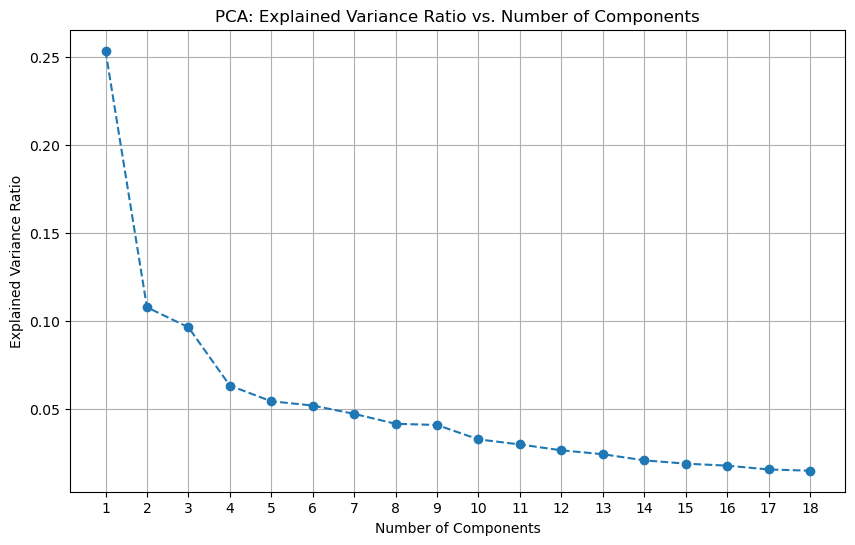

In [25]:
#Creating plot of variance explained for each component of PCA
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

# Class Imbalance Techniques

In [17]:
#Class Weights
classifier = LogisticRegression(max_iter = 100000, class_weight = 'balanced')
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
confusion_matrix(y_test, y_pred, normalize = 'true')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       381
           1       0.37      0.79      0.51        67

    accuracy                           0.77       448
   macro avg       0.66      0.78      0.68       448
weighted avg       0.87      0.77      0.80       448



In [16]:
#Handle class imbalance with RandomOverSampler
oversample = RandomOverSampler()
X_train_scaled, y_train = oversample.fit_resample(X_train_scaled, y_train)

In [ ]:
#Handle class imbalance using SMOTE
oversample = SMOTE()
X_train_scaled, y_train = oversample.fit_resample(X_train_scaled, y_train)

In [ ]:
#Handle class imbalance with RandomUnderSampler
undersample = RandomUnderSampler()
X_train_scaled, y_train = undersample.fit_resample(X_train_scaled, y_train)

In [ ]:
#Handle class imbalance with NearMiss
undersample = NearMiss()
X_train_scaled, y_train = undersample.fit_resample(X_train_scaled, y_train)

In [64]:
#Balanced
y_train.value_counts()

Response
0    1525
1    1525
Name: count, dtype: int64

# Model Development 

In [17]:
#List containing each model
model_list = []

In [18]:
#Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [19]:
#Decision Tree Classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [20]:
#Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [21]:
#KNeighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors = 20)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=20)

In [22]:
#Gradient Boost Classifier
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.05, n_estimators = 1000,
                              max_depth = 6, random_state = 42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [23]:
model_list = [lr_model, dt_model, rf_model, knn_model, xgb_model]

# GridSearch to fine-tune parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
search_param = {'max_depth': [3, 6, 10],
                'learning_rate': [.01, .05, .1, .3],
                'n_estimators': [100, 500, 1000]}
GS = GridSearchCV(estimator = xgb_model,
                 param_grid = search_param,
                 scoring = ['roc_auc', 'accuracy'],
                 refit = 'roc_auc', 
                 cv = 5,
                 verbose = 4)
GS.fit(X_train_scaled, y_train)

In [ ]:
print(GS.best_estimator_, '\n', GS.best_score_)

In [24]:
#Function to calculate training set accuracy, test set accuracy, and AUC score, and display classification report
def metric_calc(model_list, X_test_scaled, y_test):
    for elem in model_list:
        print(str(elem))
        model_predictions = elem.predict(X_test_scaled)
        print('Training Accuracy: ' + str(elem.score(X_train_scaled, y_train)))
        print('Test Accuracy: ' + str(accuracy_score(y_test, model_predictions)))
        print('AUC Score: ' + str(roc_auc_score(y_test, model_predictions)))
        print(classification_report(y_test, model_predictions))

In [25]:
metric_calc(model_list, X_test_scaled, y_test)

LogisticRegression()
Training Accuracy: 0.7770491803278688
Test Accuracy: 0.7633928571428571
AUC Score: 0.7747874799232185
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       381
           1       0.37      0.79      0.50        67

    accuracy                           0.76       448
   macro avg       0.66      0.77      0.67       448
weighted avg       0.87      0.76      0.79       448

DecisionTreeClassifier()
Training Accuracy: 0.9954098360655738
Test Accuracy: 0.8459821428571429
AUC Score: 0.6880361969679164
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       381
           1       0.48      0.46      0.47        67

    accuracy                           0.85       448
   macro avg       0.70      0.69      0.69       448
weighted avg       0.84      0.85      0.84       448

RandomForestClassifier()
Training Accuracy: 0.9954098360655738
Test Accuracy: 0.8861607142857143

Text(0.5, 1.0, 'Test Precision-Recall curve')

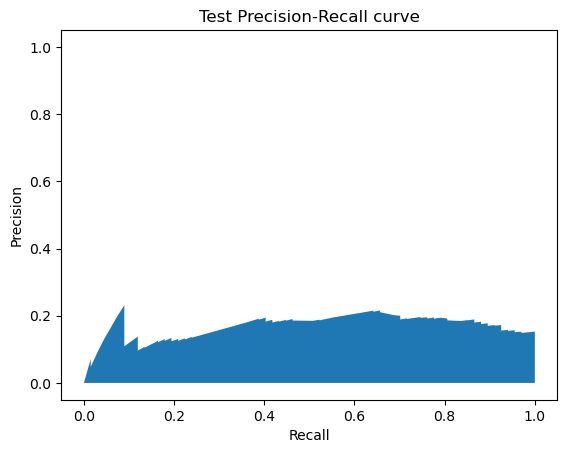

In [26]:
from sklearn.metrics import precision_recall_curve
y_prob_test = xgb_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
plt.fill_between(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Test Precision-Recall curve')

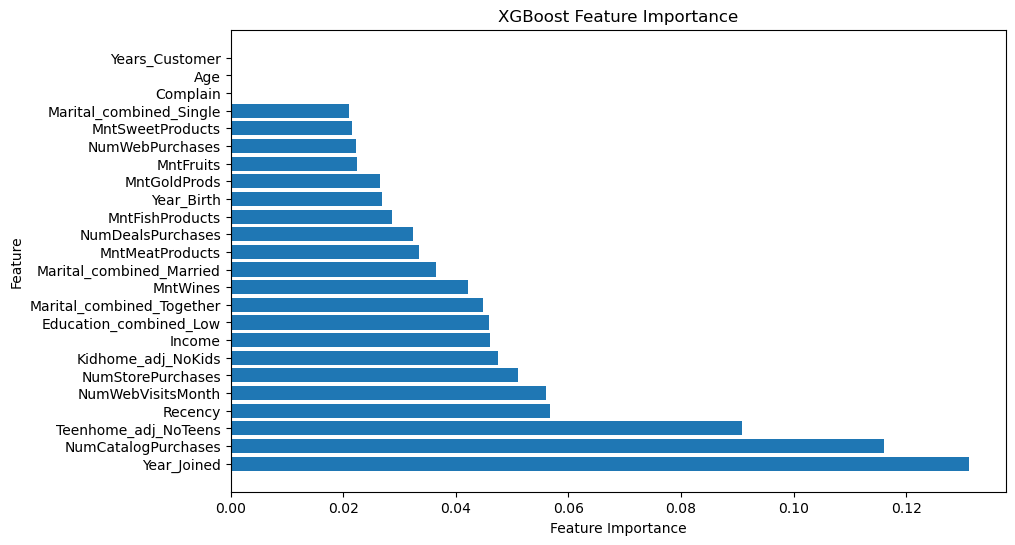

In [28]:
#Feature importances for XGBoost
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

#Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()

## Conclusion: 



The supermarket intends to propose a new gold membership for customers which would give a 20% discount on all purchases for 499 dollars instead of the usual 999 dollars. The store needs information about which customers are likely to respond positively to its new marketing campaign, and factors which can help explain consumer behavior. The year in which an individual became a customer of the supermarket is the top predictor of whether he or she will respond favorably to the marketing campaign. Generally, if customers have been shopping at this particular supermarket for a long time, then it follows that they probably frequent this store over others and consequently prefer their assortment of goods and services. Additionally, the number of catalog purchases, which captures the number of purchased goods to be shipped in the mail, is the second leading predictor, suggesting consumers who have goods delivered may purchase more frequently and see value in an overall 20% discount on future purchases. The third leading predictor is for consumers with no teenage children, which is an interesting finding. Perhaps teenagers have greater influence on their parents as to which stores to visit than younger children, and either urge them to visit this supermarket or frequent a different store. After these three leading factors, the recency of visiting the supermarket, number of website visits in the last month, and the number of store purchases represent features with relatively high predictive power. 

The supervised learning machine learning models with the greatest overall performance were the RandomForest Classifier and XGBoost Classifier. Both achieved relatively high test accuracies of about 89%; however, in this problem, we are primarily interested in the minority class of whether individuals will respond positively to the new marketing campaign, so it will likely be more beneficial to evaluate the models' performance using precision and recall. For the positive class, the RandomForest model yielded a precision of 0.70 indicating that of the consumers predicted to respond positively, about 70% of them actually responded positively. The model's recall was low at 0.42 meaning of those who actually responded positively, only roughly 42% of them were predicted to respond positively. With the XGBoost model, the precision was 0.66 and recall was 0.49. The LogisticRegression model reached the highest recall of 0.79 but had one of the lowest precisions of 0.37 for the positive class.  

## Future Direction: 

In the future, it will be beneficial for the supermarket to collect more data about different consumers since there were only 2240 instances collected which may have made it difficult for the machine learning models to achieve higher performances. The supermarket may also want to provide specific features about the marketing campaign instead of just its consumers. There may be an issue with the marketing design, message, or content which affects customers' response to the campaign. Furthermore, I would try more advanced supervised learning techniques such as neural networks or deep learning given there is more data collected in the future. With the existing models, I would spend more time fine-tuning existing parameters to see if there would be a noticeable difference in perforamance, experiment with other novel features, and try new techniques to handle class imbalance, imputation, and standardization of the data. 